# Bibliotecas

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

from stable_baselines3 import PPO, DQN 
from stable_baselines3.common.vec_env import SubprocVecEnv, VecFrameStack
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.env_checker import check_env
import ale_py

# Criar enviroment

In [15]:
# Create enviroment with SubprocVecEnv to improve performance
# Not available in notebooks
# env = make_vec_env("ALE/MsPacman-v5", n_envs=4, vec_env_cls=SubprocVecEnv)

env = make_vec_env("ALE/MsPacman-v5", n_envs=4)
    
# Stack 3 frames for temporal information
env = VecFrameStack(env, n_stack=3)

# Environment information

In [16]:
# Print environment information
print("="*60)
print("ENVIRONMENT INFORMATION")
print("="*60)
print(f"Observation Space: {env.observation_space}")
print(f"Observation Shape: {env.observation_space.shape}")
print(f"Observation dtype: {env.observation_space.dtype}")
print(f"Action Space: {env.action_space}")
print(f"Number of actions: {env.action_space.n}")
print(f"Number of parallel envs: {env.num_envs}")
print("="*60 + "\n")

ENVIRONMENT INFORMATION
Observation Space: Box(0, 255, (210, 160, 9), uint8)
Observation Shape: (210, 160, 9)
Observation dtype: uint8
Action Space: Discrete(9)
Number of actions: 9
Number of parallel envs: 4



In [17]:
# Sample an observation to see actual data
obs = env.reset()
print("="*60 + "\n")
print(f"Sample observation shape: {obs.shape}")
print(f"Sample observation dtype: {obs.dtype}")
print(f"Sample observation min/max: {obs.min()} / {obs.max()}")
print(f"Sample observation:\n{obs[0, :, :, 0]}\n")
print("="*60 + "\n")


Sample observation shape: (4, 210, 160, 9)
Sample observation dtype: uint8
Sample observation min/max: 0 / 228
Sample observation:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]




✅ Showing frame progression over time



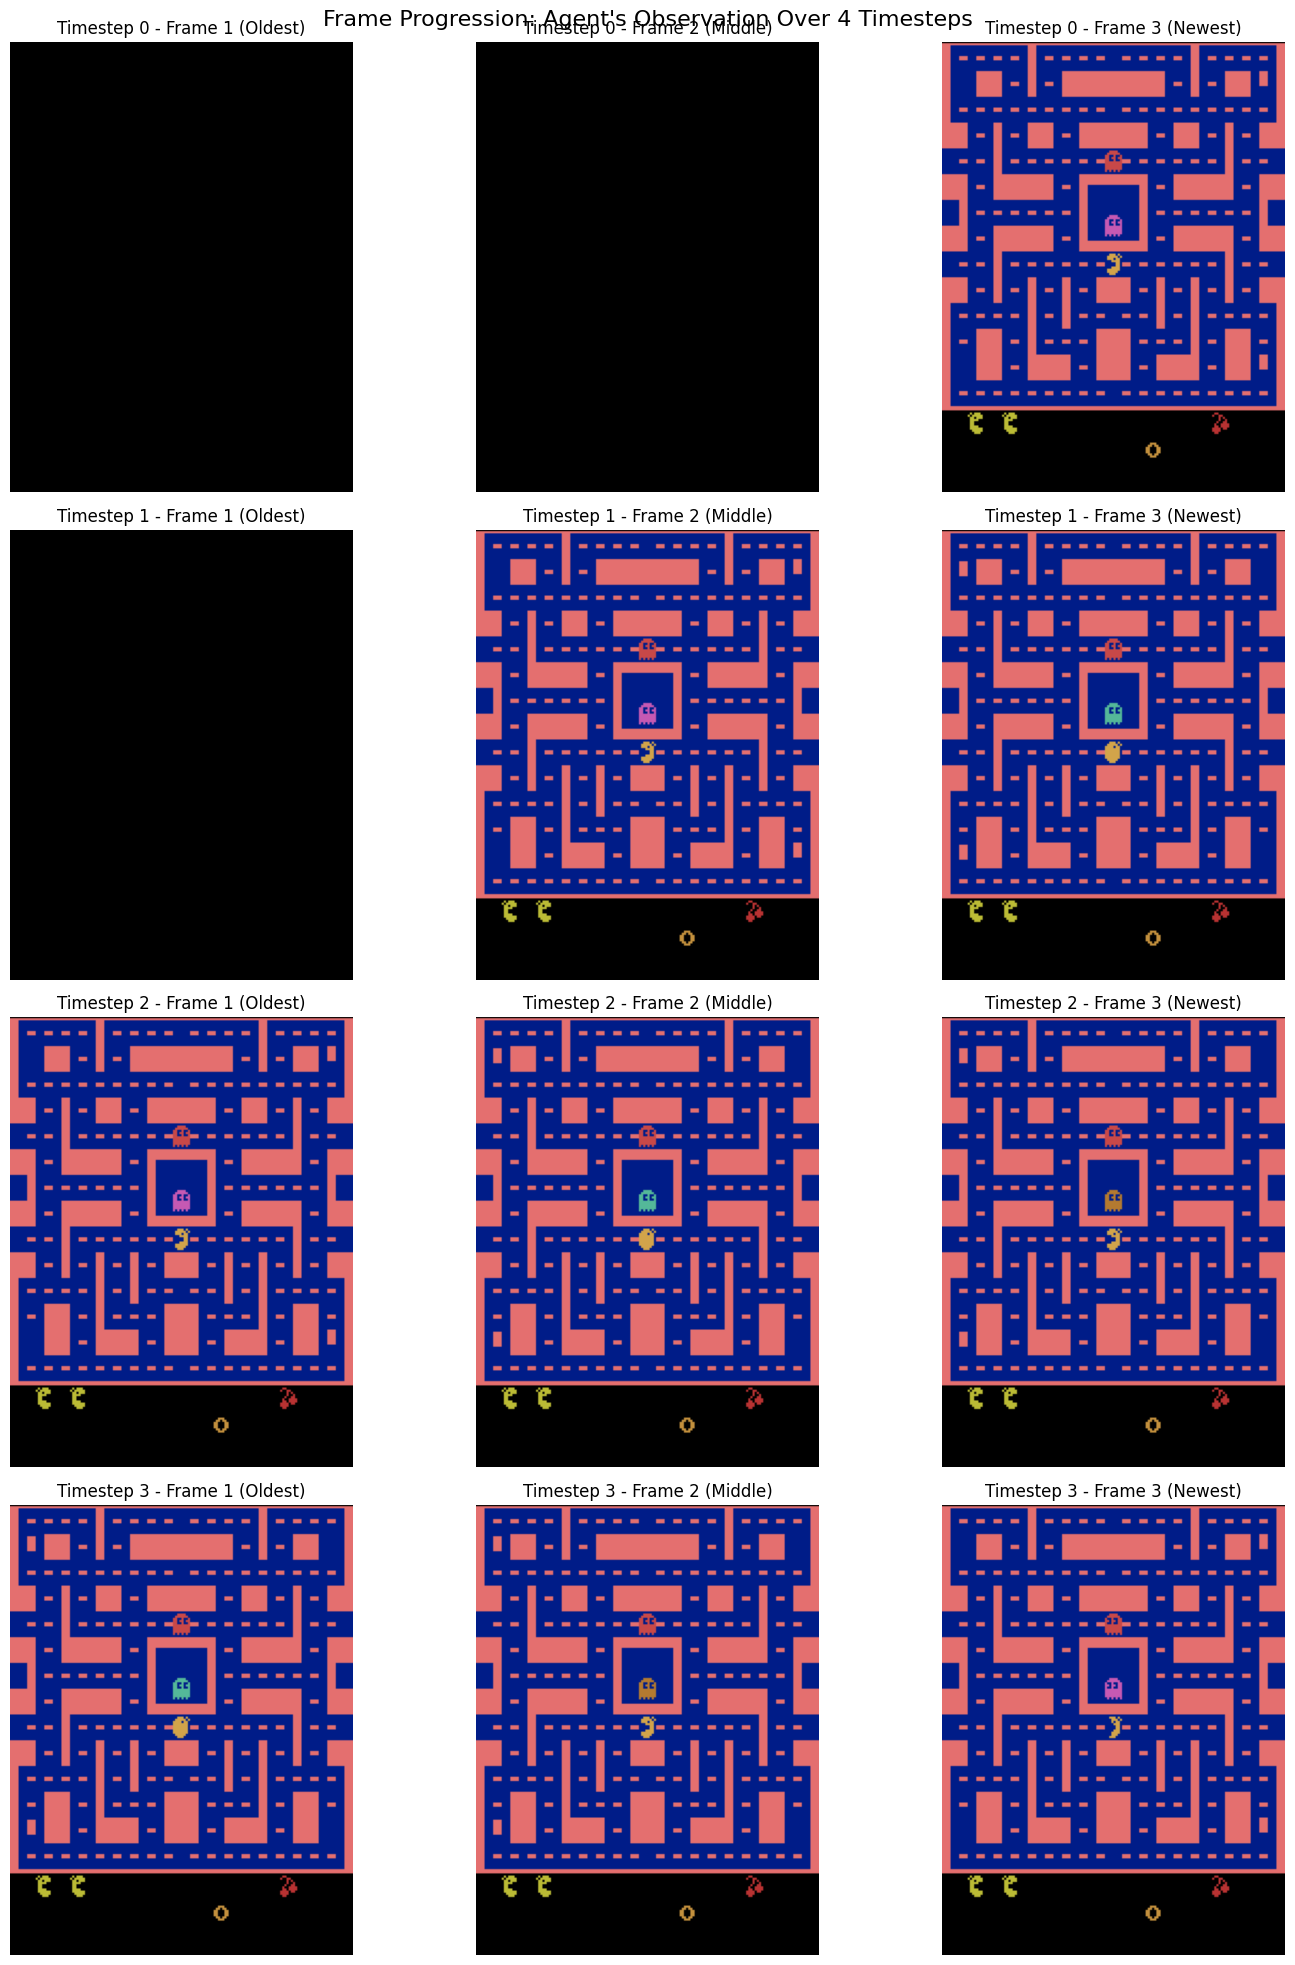

In [18]:
# Visualize the observation frames over time
# Reset environment first to ensure clean state
obs = env.reset()
observations = [obs.copy()]  # Start with initial observation

# Take 3 steps with NOOP action (action 0 = do nothing) to see frame progression
# Using NOOP to avoid game over during visualization
for i in range(3):
    # Use action 0 (NOOP) for all environments to avoid dying
    action = np.array([0, 0, 0, 0])  # NOOP for all 4 envs
    obs, reward, done, info = env.step(action)
    observations.append(obs.copy())
    
    # If any env finished, we still have the observation
    if done.any():
        print(f"Note: Episode ended at step {i+1}, but continuing visualization")

# Create a 4x3 grid: 4 timesteps (rows) x 3 stacked frames (columns)
fig, axes = plt.subplots(4, 3, figsize=(15, 20))

for timestep in range(4):
    first_env_obs = observations[timestep][0]  # Get first environment
    
    # Extract the 3 stacked frames
    frame1 = first_env_obs[:, :, 0:3]  # Frame 1 (oldest)
    frame2 = first_env_obs[:, :, 3:6]  # Frame 2 (middle)
    frame3 = first_env_obs[:, :, 6:9]  # Frame 3 (newest)
    
    # Plot each frame
    axes[timestep, 0].imshow(frame1)
    axes[timestep, 0].set_title(f"Timestep {timestep} - Frame 1 (Oldest)")
    axes[timestep, 0].axis('off')
    
    axes[timestep, 1].imshow(frame2)
    axes[timestep, 1].set_title(f"Timestep {timestep} - Frame 2 (Middle)")
    axes[timestep, 1].axis('off')
    
    axes[timestep, 2].imshow(frame3)
    axes[timestep, 2].set_title(f"Timestep {timestep} - Frame 3 (Newest)")
    axes[timestep, 2].axis('off')

plt.suptitle("Frame Progression: Agent's Observation Over 4 Timesteps", fontsize=16)
plt.tight_layout()
print(f"✅ Showing frame progression over time\n")
plt.show()

# Create Model

In [19]:
model = PPO("CnnPolicy", env, device="cpu", verbose=1)
model.learn(total_timesteps=300)

Using cpu device
Wrapping the env in a VecTransposeImage.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 478      |
|    ep_rew_mean     | 239      |
| time/              |          |
|    fps             | 229      |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 8192     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 478      |
|    ep_rew_mean     | 239      |
| time/              |          |
|    fps             | 229      |
|    iterations      | 1        |
|    time_elapsed    | 35       |
|    total_timesteps | 8192     |
---------------------------------


In [ ]:
# Testing the trained model
vec_env = model.get_env()
obs = vec_env.reset()
total_score = 0


for i in range(1000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = vec_env.step(action)
    vec_env.render("human")
    
    # Access lives and score from info dict (for each parallel environment)
    for env_idx, episode_info in enumerate(info):
        # Print all available keys in info to debug
        if i < 5 and env_idx == 0:  # Debug first few steps
            print(f"Info keys: {episode_info.keys()}")
        
        # Try different possible keys for score
        score = episode_info.get('episode', {}).get('r', 'N/A') # não recebe score
        lives = episode_info.get('lives', 'N/A')
        
        # Check if this specific env finished
        if done[env_idx]:
            print(f"\n🎮 Env {env_idx} - Episode finished!\n Info: {episode_info}")
            final_score = episode_info.get('episode', {}).get('r', 'N/A')
            #print(f"\n🎮 Env {env_idx} - Episode finished! Final Score: {final_score}, Lives: {lives}\n")
    
    # VecEnv resets automatically when any env is done
    # No need to manually reset

Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number', 'TimeLimit.truncated'])
Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number', 'TimeLimit.truncated'])
Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number', 'TimeLimit.truncated'])
Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number', 'TimeLimit.truncated'])
Info keys: dict_keys(['lives', 'episode_frame_number', 'frame_number', 'TimeLimit.truncated'])

🎮 Env 2 - Episode finished!
 Info: {'lives': 0, 'episode_frame_number': 1769, 'frame_number': 9961, 'episode': {'r': 190.0, 'l': 443, 't': 1580.890148}, 'TimeLimit.truncated': False, 'terminal_observation': array([[[  0,   0,   0, ...,   0,   0,   0],
        [228, 228, 228, ..., 228, 228, 228],
        [228, 228, 228, ..., 228, 228, 228],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0